In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
import numpy as np
import folium
import geopandas as gpd
import folium
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import itertools
from folium.plugins import MarkerCluster
import re
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from matplotlib.animation import FuncAnimation
from scipy.stats import gaussian_kde
import time
from shapely.geometry import Point
import contextily as ctx
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

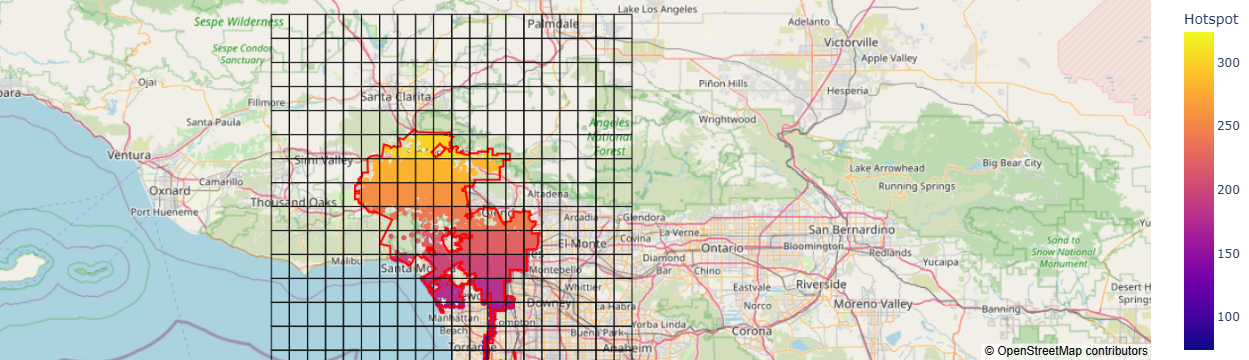

In [3]:
# grid_spatial_clustering.py

import pandas as pd
import numpy as np
import plotly.express as px
import json

# Load the data
df = pd.read_csv("Time_formatted_fixed_loc.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df[['Datetime', 'LAT', 'LON']].dropna()

# Define grid bin edges
min_lat, max_lat = 33.5, 34.6
min_lon, max_lon = -118.9, -117.9
lat_bins, lon_bins = 20, 20

lat_edges = np.linspace(min_lat, max_lat, lat_bins + 1)
lon_edges = np.linspace(min_lon, max_lon, lon_bins + 1)

# Bin data into grid cells
df['lat_bin'] = np.digitize(df['LAT'], lat_edges) - 1
df['lon_bin'] = np.digitize(df['LON'], lon_edges) - 1

# Remove out-of-bounds
df = df[
    (df['lat_bin'] >= 0) & (df['lat_bin'] < lat_bins) &
    (df['lon_bin'] >= 0) & (df['lon_bin'] < lon_bins)
]

# Assign Hotspot ID based on grid location
df['Hotspot'] = df['lat_bin'] * (lon_bins + 1) + df['lon_bin']

# Load LA boundary GeoJSON
with open("la_boundary.geojson", "r") as f:
    la_boundary = json.load(f)

# Generate Grid GeoJSON
grid_lines = []
for i in range(lat_bins):
    for j in range(lon_bins):
        lat1 = lat_edges[i]
        lat2 = lat_edges[i + 1]
        lon1 = lon_edges[j]
        lon2 = lon_edges[j + 1]
        grid_lines.append({
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [[
                    [lon1, lat1],
                    [lon2, lat1],
                    [lon2, lat2],
                    [lon1, lat2],
                    [lon1, lat1]
                ]]
            },
            "properties": {
                "grid_id": f"{i}_{j}"
            }
        })

grid_geojson = {
    "type": "FeatureCollection",
    "features": grid_lines
}

# Visualize using original coordinates
fig = px.scatter_mapbox(
    df.sample(frac=0.05, random_state=42),
    lat="LAT",
    lon="LON",
    color="Hotspot",
    zoom=9.5,
    center={"lat": 34.05, "lon": -118.25},
    height=800
)

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_layers=[
        {"source": la_boundary, "type": "line", "color": "red"},
        {"source": grid_geojson, "type": "line", "color": "black", "line": {"width": 1}},
    ],
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.show()


In [4]:
df['Hotspot'].value_counts()

Hotspot
222    35543
201    31073
180    26293
221    24672
202    15662
       ...  
277        2
322        2
140        1
163        1
161        1
Name: count, Length: 80, dtype: int64

In [5]:
import pandas as pd

# 1. Convert the full datetime to just date (daily frequency)
df['Date'] = df['Datetime'].dt.to_period('D').apply(lambda r: r.start_time)

# 2. Group by Date and Hotspot to count number of crimes
time_series = df.groupby(['Date', 'Hotspot']).size().reset_index(name='CrimeCount')

# 3. Pivot table: Dates as index, Hotspots as columns, CrimeCounts as values
ts_pivot = time_series.pivot(index='Date', columns='Hotspot', values='CrimeCount').fillna(0)

# 4. Make sure the index is datetime type
ts_pivot.index = pd.to_datetime(ts_pivot.index)

# 5. Sort the index
ts_pivot = ts_pivot.sort_index()

# 6. Create a complete daily date range to fill missing days
full_index = pd.date_range(start=ts_pivot.index.min(), end=ts_pivot.index.max(), freq='D')

# 7. Reindex with full daily date range and fill missing values with 0
ts_pivot = ts_pivot.reindex(full_index, fill_value=0)

# 8. Rename index to 'Datetime'
ts_pivot.index.name = 'Datetime'


In [6]:
ts_pivot.head()

Hotspot     74   75   95    96   97   116  117  118  137  138  ...  300  301  \
Datetime                                                       ...             
2020-01-01  0.0  0.0  0.0   2.0  0.0  0.0  2.0  0.0  0.0  0.0  ...  0.0  0.0   
2020-01-02  0.0  0.0  0.0  14.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  1.0  0.0   
2020-01-03  0.0  1.0  1.0   4.0  0.0  1.0  4.0  0.0  0.0  0.0  ...  0.0  1.0   
2020-01-04  2.0  0.0  0.0   2.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  4.0   
2020-01-05  1.0  0.0  0.0   0.0  0.0  0.0  1.0  3.0  0.0  0.0  ...  0.0  5.0   

Hotspot     302  303  304  305  306  322  323  324  
Datetime                                            
2020-01-01  2.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-02  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  
2020-01-03  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  
2020-01-04  3.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-05  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 80 columns]

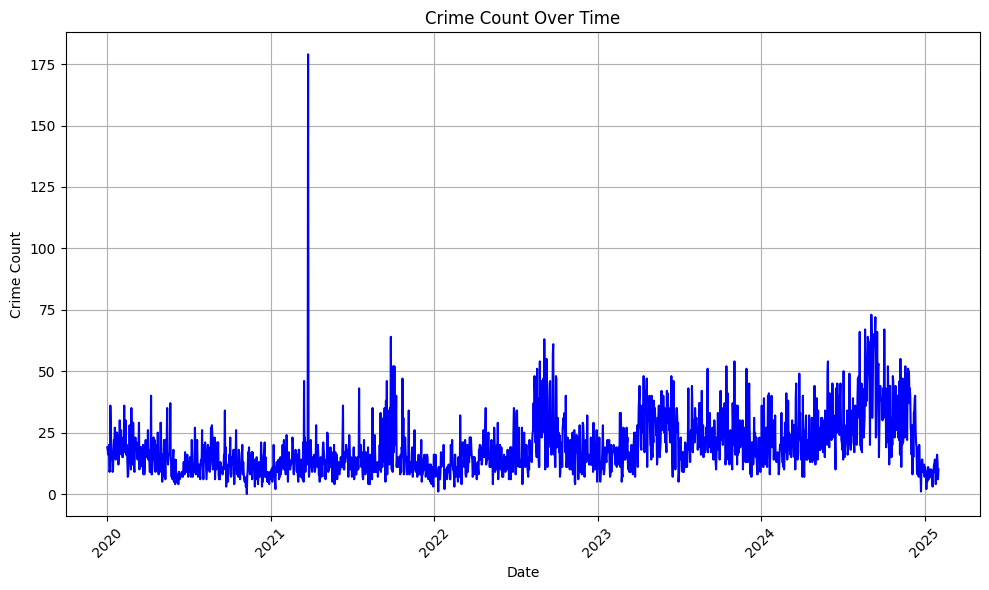

In [7]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot.index, ts_pivot[222], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')    
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

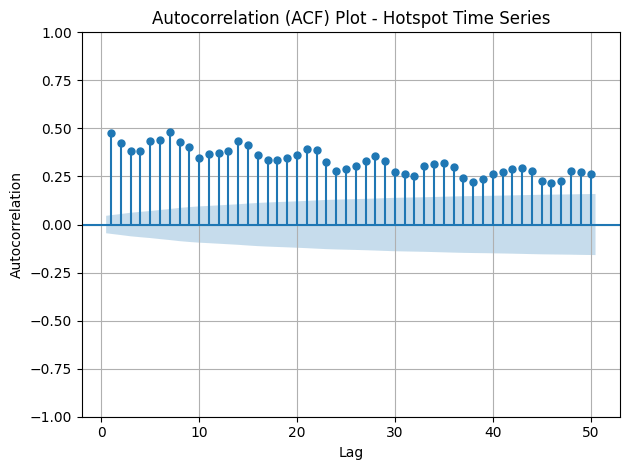

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[222].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm

warnings.filterwarnings("ignore")
hotspot_series = ts_pivot[222].values
dates = ts_pivot.index

# === Train-Test Split (80/20) ===
split_idx = int(len(hotspot_series) * 0.8)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")


== ADF Stationarity Test ==
ADF Statistic: -4.0472
p-value: 0.0012
=> Stationary


In [10]:
# Use the raw values directly for training and testing

hotspot_series = ts_pivot[222].values  # Use the original values (no scaling)

# --- Train/test split (80/20) on the raw time series ---
split_idx = int(len(hotspot_series) * 0.8)
y_train = hotspot_series[:split_idx]
y_test = hotspot_series[split_idx:]

# Print some of the data values for verification
print("y_train (original data):", y_train[:5])  # Print the first 5 values of y_train
print("y_test (original data):", y_test[:5])  # Print the first 5 values of y_test

y_train (original data): [19. 18. 16. 16. 20.]
y_test (original data): [19. 20. 30. 14. 24.]


In [11]:
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Preprocessing ---
hotspot_series = ts_pivot[222].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_scaled = hotspot_scaled[:split_idx].flatten()
test_scaled = hotspot_scaled[split_idx:].flatten()

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

warnings.filterwarnings('ignore')

# --- Fit AR models with different lags and select best ---
best_ar_rmse = float('inf')
best_ar_lag = None

for lag in range(1, 40):  # test lags from 1 to 40
    try:
        model_ar = AutoReg(train_scaled, lags=lag, old_names=False).fit()
        pred_scaled = model_ar.predict(start=len(train_scaled), end=len(train_scaled) + len(test_scaled) - 1)
        pred = inverse_transform(pred_scaled)
        actual = inverse_transform(test_scaled)

        rmse = mean_squared_error(actual, pred, squared=False)
        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred
            best_ar_actual = actual
    except:
        continue

# --- Output ---
print(f"Best AR Lag: {best_ar_lag}")
print(f"AR RMSE: {best_ar_rmse:.2f}")
print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred)*100:.2f}%")


Best AR Lag: 35
AR RMSE: 16.90
AR MAPE: 53.62%


In [12]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

hotspot_series = ts_pivot[222].values.flatten()

# --- Train/Test split (80/20) ---
split_idx = int(len(hotspot_series) * 0.8)
train = hotspot_series[:split_idx]
test = hotspot_series[split_idx:]

# Suppress warnings
warnings.filterwarnings('ignore')

# Define parameter ranges
p = d = q = range(0, 2)
P = D = Q = range(0, 3)
s = 7  # Weekly seasonality

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            pred = model.forecast(steps=len(test))

            rmse = mean_squared_error(test, pred, squared=False)
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
                best_pred = pred
                best_actual = test
        except:
            continue

# --- Output Best SARIMA Model ---
print(f"Best SARIMA Order: {best_order}, Seasonal: {best_seasonal_order} x {s}")
print(f"SARIMA RMSE: {best_rmse:.2f}")
print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_actual, best_pred)*100:.2f}%")


Best SARIMA Order: (0, 1, 1), Seasonal: (0, 1, 1) x 7
SARIMA RMSE: 13.94
SARIMA MAPE: 66.13%


In [13]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[222].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 13.66
XGBoost MAPE: 45.68%



For lag = 1
Test RMSE: 13.4742
MAPE: 40.41%

For lag = 2
Test RMSE: 12.0522
MAPE: 38.29%

For lag = 3
Test RMSE: 11.6677
MAPE: 39.30%

For lag = 4
Test RMSE: 11.3930
MAPE: 39.45%

For lag = 6
Test RMSE: 10.9027
MAPE: 39.36%

For lag = 9
Test RMSE: 10.6834
MAPE: 39.91%

For lag = 12
Test RMSE: 10.7053
MAPE: 40.28%

For lag = 16
Test RMSE: 10.5987
MAPE: 41.65%

For lag = 24
Test RMSE: 10.5515
MAPE: 41.21%

For lag = 30
Test RMSE: 10.6102
MAPE: 42.69%

For lag = 40
Test RMSE: 10.5755
MAPE: 42.98%

For lag = 50
Test RMSE: 10.6204
MAPE: 43.24%


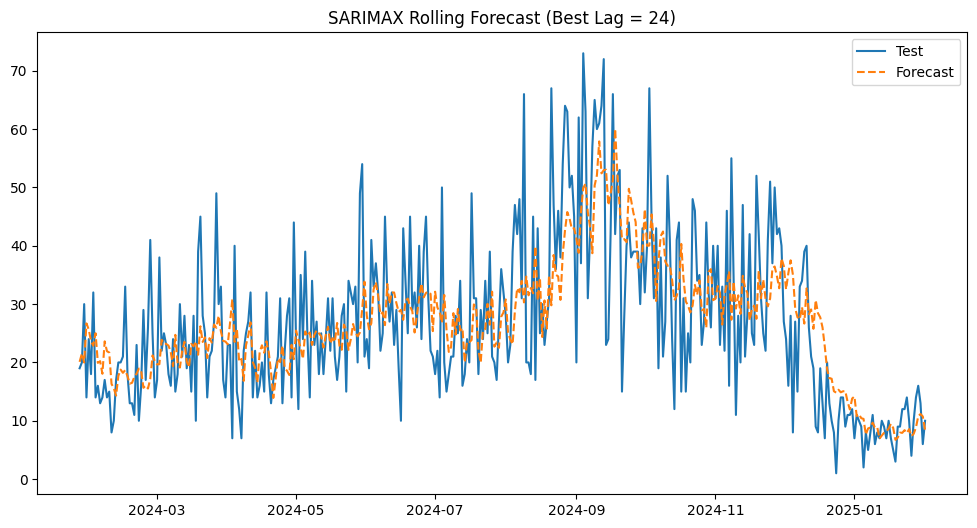

In [14]:
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[222].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


Epoch 1, Loss: 0.5216
Epoch 2, Loss: 0.5059
Epoch 3, Loss: 0.4932
Epoch 4, Loss: 0.4848
Epoch 5, Loss: 0.4823
Epoch 6, Loss: 0.4825
Epoch 7, Loss: 0.4855
Epoch 8, Loss: 0.4805
Epoch 9, Loss: 0.4794
Epoch 10, Loss: 0.4746
Epoch 11, Loss: 0.4754
Epoch 12, Loss: 0.4677
Epoch 13, Loss: 0.4730
Epoch 14, Loss: 0.4710
Epoch 15, Loss: 0.4717
Epoch 16, Loss: 0.4634
Epoch 17, Loss: 0.4624
Epoch 18, Loss: 0.4611
Epoch 19, Loss: 0.4628
Epoch 20, Loss: 0.4642
Epoch 21, Loss: 0.4586
Epoch 22, Loss: 0.4638
Epoch 23, Loss: 0.4596
Epoch 24, Loss: 0.4556
Epoch 25, Loss: 0.4600
Epoch 26, Loss: 0.4550
Epoch 27, Loss: 0.4638
Epoch 28, Loss: 0.4582
Epoch 29, Loss: 0.4576
Epoch 30, Loss: 0.4539
Epoch 31, Loss: 0.4614
Epoch 32, Loss: 0.4571
Epoch 33, Loss: 0.4515
Epoch 34, Loss: 0.4550
Epoch 35, Loss: 0.4476
Epoch 36, Loss: 0.4455
Epoch 37, Loss: 0.4544
Epoch 38, Loss: 0.4476
Epoch 39, Loss: 0.4470
Epoch 40, Loss: 0.4417
Epoch 41, Loss: 0.4439
Epoch 42, Loss: 0.4367
Epoch 43, Loss: 0.4332
Epoch 44, Loss: 0.43

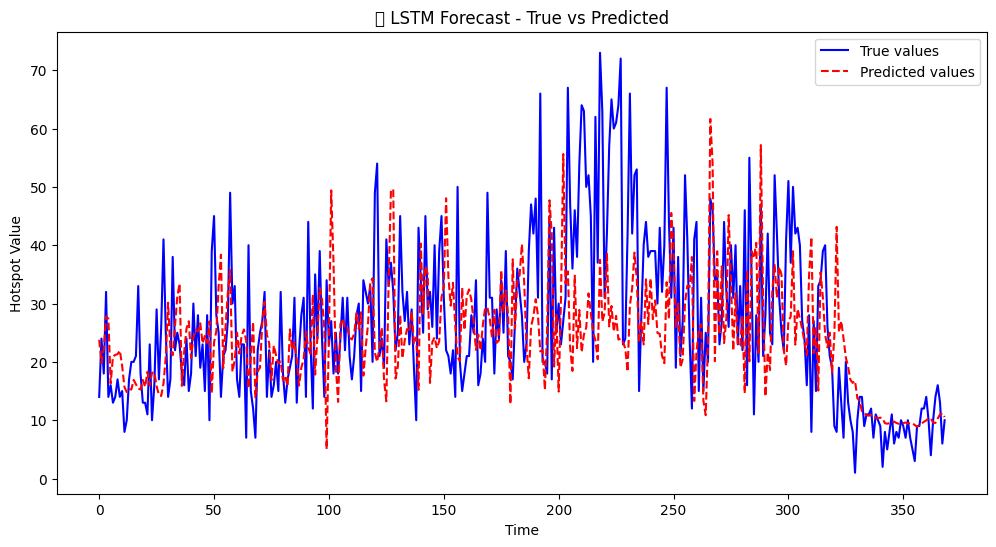

 Test RMSE: 13.8433
 Test MAPE: 46.52%


In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Use your actual ts_pivot DataFrame
series = ts_pivot[222].dropna().values.reshape(-1, 1)

# Normalize using robust scaler to reduce influence of outliers
scaler = RobustScaler()
series_scaled = scaler.fit_transform(series)

# Sequence creation function
def create_sequences(data, seq_len=14):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Generate sequences
SEQ_LEN = 14
X, y = create_sequences(series_scaled, SEQ_LEN)

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define LSTM model
class BetterLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3):
        super(BetterLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # get last time step
        return self.fc(out)

# Initialize model
model = BetterLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
EPOCHS = 200
best_loss = float('inf')
patience, wait = 10, 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        wait = 0
        best_model_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

# Load best model
model.load_state_dict(best_model_state)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='True values', color='blue')
plt.plot(y_pred_inv, label='Predicted values', color='red', linestyle='--')
plt.title("📈 LSTM Forecast - True vs Predicted")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print(f" Test RMSE: {rmse:.4f}")
print(f" Test MAPE: {mape * 100:.2f}%")


### Second Largest Cluster

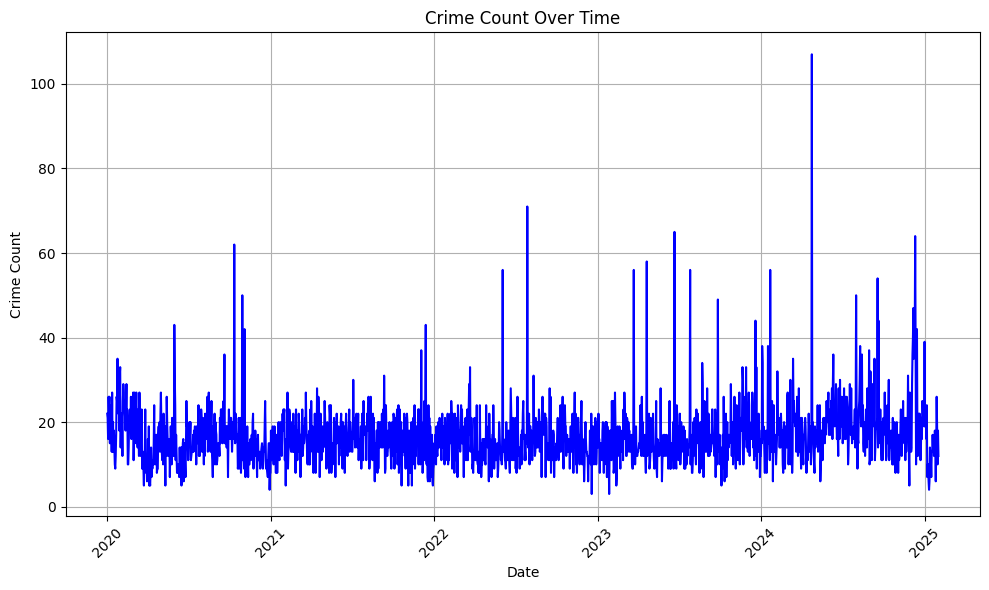

In [19]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot.index, ts_pivot[201], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')    
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

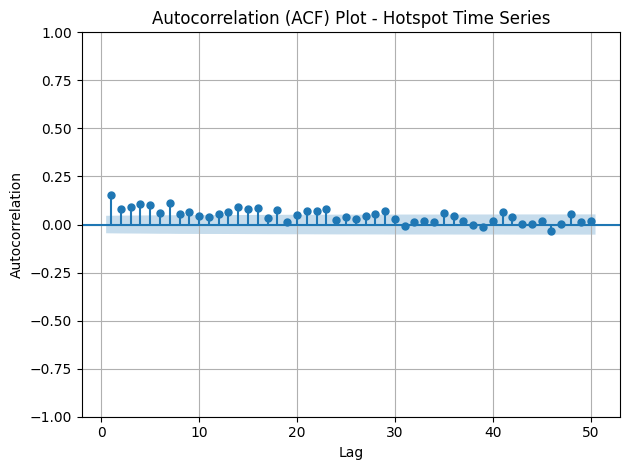

In [20]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[201].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm

# --- Suppress warnings and logs ---
warnings.filterwarnings("ignore")
hotspot_series = ts_pivot[201].values
dates = ts_pivot.index

# === Train-Test Split (80/10) ===
split_idx = int(len(hotspot_series) * 0.8)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")


== ADF Stationarity Test ==
ADF Statistic: -12.1693
p-value: 0.0000
=> Stationary


In [22]:

hotspot_series = ts_pivot[201].values  # Use the original values (no scaling)

# --- Train/test split (80/20) on the raw time series ---
split_idx = int(len(hotspot_series) * 0.8)
y_train = hotspot_series[:split_idx]
y_test = hotspot_series[split_idx:]

# Now, y_train and y_test contain the raw data without any scaling.
# Print some of the data values for verification
print("y_train (original data):", y_train[:5])  # Print the first 5 values of y_train
print("y_test (original data):", y_test[:5])  # Print the first 5 values of y_test

y_train (original data): [22. 21. 16. 26. 22.]
y_test (original data): [21.  6. 19. 24. 13.]


In [23]:
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Preprocessing ---
hotspot_series = ts_pivot[201].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_scaled = hotspot_scaled[:split_idx].flatten()
test_scaled = hotspot_scaled[split_idx:].flatten()

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# Suppress all warnings
warnings.filterwarnings('ignore')

# --- Fit AR models with different lags and select best ---
best_ar_rmse = float('inf')
best_ar_lag = None

for lag in range(1, 40):  # test lags from 1 to 40
    try:
        model_ar = AutoReg(train_scaled, lags=lag, old_names=False).fit()
        pred_scaled = model_ar.predict(start=len(train_scaled), end=len(train_scaled) + len(test_scaled) - 1)
        pred = inverse_transform(pred_scaled)
        actual = inverse_transform(test_scaled)

        rmse = mean_squared_error(actual, pred, squared=False)
        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred
            best_ar_actual = actual
    except:
        continue

# --- Output ---
print(f"Best AR Lag: {best_ar_lag}")
print(f"AR RMSE: {best_ar_rmse:.2f}")
print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred)*100:.2f}%")


Best AR Lag: 21
AR RMSE: 9.32
AR MAPE: 30.41%


In [24]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

hotspot_series = ts_pivot[201].values.flatten()

# --- Train/Test split (80/20) ---
split_idx = int(len(hotspot_series) * 0.8)
train = hotspot_series[:split_idx]
test = hotspot_series[split_idx:]

# Suppress warnings
warnings.filterwarnings('ignore')

# Define parameter ranges
p = d = q = range(0, 2)
P = D = Q = range(0, 3)
s = 7  # Weekly seasonality

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            pred = model.forecast(steps=len(test))

            rmse = mean_squared_error(test, pred, squared=False)
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
                best_pred = pred
                best_actual = test
        except:
            continue

# --- Output Best SARIMA Model ---
print(f"Best SARIMA Order: {best_order}, Seasonal: {best_seasonal_order} x {s}")
print(f"SARIMA RMSE: {best_rmse:.2f}")
print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_actual, best_pred)*100:.2f}%")


Best SARIMA Order: (1, 1, 1), Seasonal: (0, 1, 1) x 7
SARIMA RMSE: 8.88
SARIMA MAPE: 38.63%


In [25]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[201].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 9.56
XGBoost MAPE: 34.97%



For lag = 1
Test RMSE: 10.7471
MAPE: 37.02%

For lag = 2
Test RMSE: 9.9024
MAPE: 35.90%

For lag = 3
Test RMSE: 9.3165
MAPE: 34.48%

For lag = 4
Test RMSE: 9.0057
MAPE: 33.55%

For lag = 6
Test RMSE: 9.0746
MAPE: 34.99%

For lag = 9
Test RMSE: 8.9489
MAPE: 34.68%

For lag = 12
Test RMSE: 8.9792
MAPE: 35.18%

For lag = 16
Test RMSE: 8.9202
MAPE: 34.95%

For lag = 24
Test RMSE: 8.8967
MAPE: 34.91%

For lag = 30
Test RMSE: 9.0327
MAPE: 35.97%

For lag = 40
Test RMSE: 9.0820
MAPE: 36.41%

For lag = 50
Test RMSE: 9.0101
MAPE: 36.48%


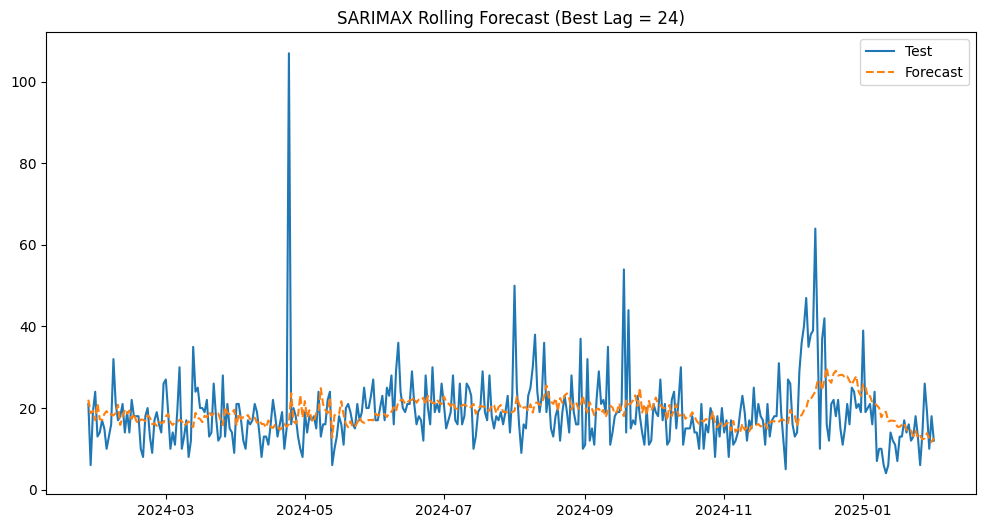

In [26]:
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[201].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


Epoch 1, Loss: 0.7404
Epoch 2, Loss: 0.7312
Epoch 3, Loss: 0.7314
Epoch 4, Loss: 0.7291
Epoch 5, Loss: 0.7316
Epoch 6, Loss: 0.7282
Epoch 7, Loss: 0.7255
Epoch 8, Loss: 0.7267
Epoch 9, Loss: 0.7259
Epoch 10, Loss: 0.7278
Epoch 11, Loss: 0.7268
Epoch 12, Loss: 0.7206
Epoch 13, Loss: 0.7994
Epoch 14, Loss: 0.7196
Epoch 15, Loss: 0.7194
Epoch 16, Loss: 0.7146
Epoch 17, Loss: 0.7169
Epoch 18, Loss: 0.7171
Epoch 19, Loss: 0.7261
Epoch 20, Loss: 0.7125
Epoch 21, Loss: 0.7095
Epoch 22, Loss: 0.7043
Epoch 23, Loss: 0.7089
Epoch 24, Loss: 0.7068
Epoch 25, Loss: 0.6958
Epoch 26, Loss: 0.6993
Epoch 27, Loss: 0.6978
Epoch 28, Loss: 0.6930
Epoch 29, Loss: 0.6949
Epoch 30, Loss: 0.6972
Epoch 31, Loss: 0.6936
Epoch 32, Loss: 0.6839
Epoch 33, Loss: 0.6876
Epoch 34, Loss: 0.6875
Epoch 35, Loss: 0.6796
Epoch 36, Loss: 0.6732
Epoch 37, Loss: 0.6847
Epoch 38, Loss: 0.6669
Epoch 39, Loss: 0.6605
Epoch 40, Loss: 0.6566
Epoch 41, Loss: 0.6457
Epoch 42, Loss: 0.6326
Epoch 43, Loss: 0.6344
Epoch 44, Loss: 0.63

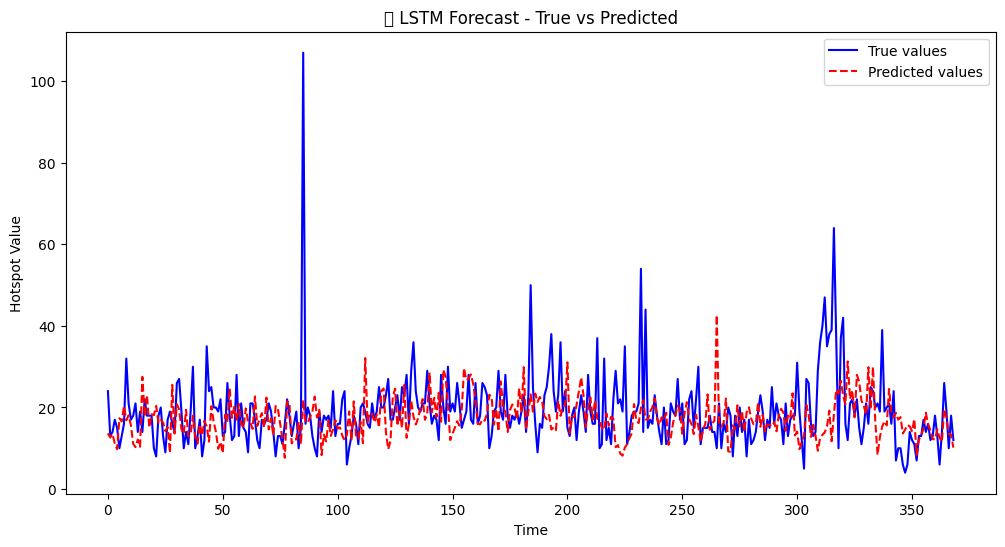

 Test RMSE: 9.9497
 Test MAPE: 36.97%


In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Use your actual ts_pivot DataFrame
series = ts_pivot[201].dropna().values.reshape(-1, 1)

# Normalize using robust scaler to reduce influence of outliers
scaler = RobustScaler()
series_scaled = scaler.fit_transform(series)

# Sequence creation function
def create_sequences(data, seq_len=14):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Generate sequences
SEQ_LEN = 14
X, y = create_sequences(series_scaled, SEQ_LEN)

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define LSTM model
class BetterLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3):
        super(BetterLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # get last time step
        return self.fc(out)

# Initialize model
model = BetterLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
EPOCHS = 200
best_loss = float('inf')
patience, wait = 10, 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        wait = 0
        best_model_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

# Load best model
model.load_state_dict(best_model_state)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='True values', color='blue')
plt.plot(y_pred_inv, label='Predicted values', color='red', linestyle='--')
plt.title("📈 LSTM Forecast - True vs Predicted")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print(f" Test RMSE: {rmse:.4f}")
print(f" Test MAPE: {mape * 100:.2f}%")
